In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.special import erf
import seaborn as sns

from emulate import compound_mesh, setup_rc_params
from emulate.graphs import PRED_KWARGS, FULL_KWARGS

In [2]:
setup_rc_params(dpi=1000)
sns.set_palette("pastel")

# Galerkin Method for Poisson's Equation

[The weak form of Poisson's Equation](https://en.wikipedia.org/wiki/Weak_formulation#Example_2:_Poisson's_equation)
[The solution for a gaussian charge density](https://en.wikipedia.org/wiki/Poisson%27s_equation#Potential_of_a_Gaussian_charge_density)

In [3]:
class GaussianCharge:
    
    def __init__(self, r, dr, nugget=1e-12):
        self.r = r
        self.dr = dr
        self.nugget = nugget
        
    def predict(self, p, use_full_solution=False):
        if use_full_solution:
            return self.predict_full(p)
        else:
            return self.emulate(p)
        
    def predict_full(self, p):
        Q, sigma = p
        r = self.r
        return Q / r * erf(r / (np.sqrt(2) * sigma)) / (4 * np.pi)
    
    def predict_grad(self, p):
        Q, sigma = p
        erf_factor = erf(r / (np.sqrt(2) * sigma))
        grad_erf = 2 / np.sqrt(np.pi) * np.exp(-(r / (np.sqrt(2) * sigma))**2) / (np.sqrt(2) * sigma)
        grad_func = - Q / r**2 * erf_factor + Q / r * grad_erf
        return grad_func / (4 * np.pi)
    
    def charge_density(self, p):
        Q, sigma = p
        pre = Q / (sigma * np.sqrt(2 * np.pi)) ** 3
        return pre * np.exp(-self.r**2 / (2 * sigma**2))
    
    def fit(self, p_train):
        pred_grad_train = []
        pred_train = []
        density_train = []
        for p in p_train:
            pred_train.append(self.predict_full(p))
            pred_grad_train.append(self.predict_grad(p))
            density_train.append(self.charge_density(p))
        pred_train = np.stack(pred_train, axis=1)
        pred_grad_train = np.stack(pred_grad_train, axis=1)
        density_train = np.stack(density_train, axis=1)
        A = (pred_grad_train.T * self.r**2 * self.dr) @ pred_grad_train
        
        self.p_train = p_train
        self.pred_train = pred_train
        self.pred_grad_train = pred_grad_train
        self.A = A + self.nugget * np.eye(A.shape[0])

    def coeffs(self, p):
        density = self.charge_density(p)
        r, dr = self.r, self.dr
        measure = (r**2 * dr)[:, None]
        density_integral = np.sum(density[:, None] * self.pred_train * measure, axis=0)
        coeffs = np.linalg.solve(self.A, density_integral)
        return coeffs
        
    def emulate(self, p):
        coeffs = self.coeffs(p)
        return self.pred_train @ coeffs

In [4]:
r, dr = compound_mesh('0 0.5 1 2 5 10 30 100', "100 30 30 100 100 100 100 100")

# p_train = np.array([
#     [0.1, 0.1],
#     [1, 1],
#     [2, 2],
#     [6, 6],
#     [3, 20]
# ])
n_train = 15
# rng_train = np.random.default_rng(5)
# p_train = 10 * rng_train.uniform(size=(30, 2))
# p_train = np.stack([np.ones(n_train), np.linspace(1e-3, 10, n_train)], axis=1)
p_train = np.stack([np.ones(n_train), np.logspace(-0.3, 1, n_train)], axis=1)

charge = GaussianCharge(r=r, dr=dr, nugget=1e-100)
charge.fit(p_train)

In [5]:
p_train

array([[ 1.        ,  0.50118723],
       [ 1.        ,  0.62066484],
       [ 1.        ,  0.76862461],
       [ 1.        ,  0.95185639],
       [ 1.        ,  1.17876863],
       [ 1.        ,  1.4597743 ],
       [ 1.        ,  1.80776868],
       [ 1.        ,  2.23872114],
       [ 1.        ,  2.772408  ],
       [ 1.        ,  3.43332002],
       [ 1.        ,  4.2517863 ],
       [ 1.        ,  5.26536608],
       [ 1.        ,  6.52057229],
       [ 1.        ,  8.07500606],
       [ 1.        , 10.        ]])

In [6]:
rng = np.random.default_rng(1)
n_valid = 5
# p_valid = 10 * rng.uniform(size=(5, 2))
# p_valid = np.stack([np.ones(n_valid), rng.uniform(low=0.5, high=10, size=n_valid)], axis=1)
p_valid = np.stack([rng.uniform(low=0.5, high=10, size=n_valid), rng.uniform(low=0.5, high=10, size=n_valid)], axis=1)

In [7]:
r_mask = r < 30

(-1.0, 0.2)

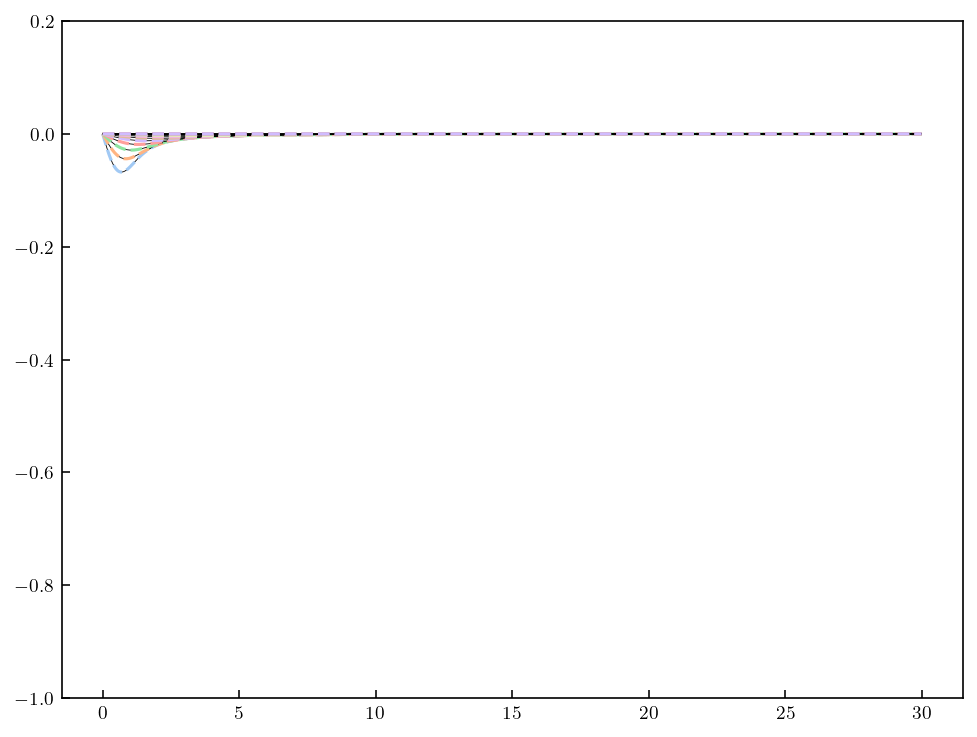

In [8]:
for i in range(len(p_train)):
    plt.plot(r[r_mask], np.gradient(charge.pred_train[r_mask, i], r[r_mask], axis=0), c='k', lw=0.4)
    plt.plot(r[r_mask], charge.pred_grad_train[r_mask, i], ls='--')
plt.ylim(-1, 0.2)

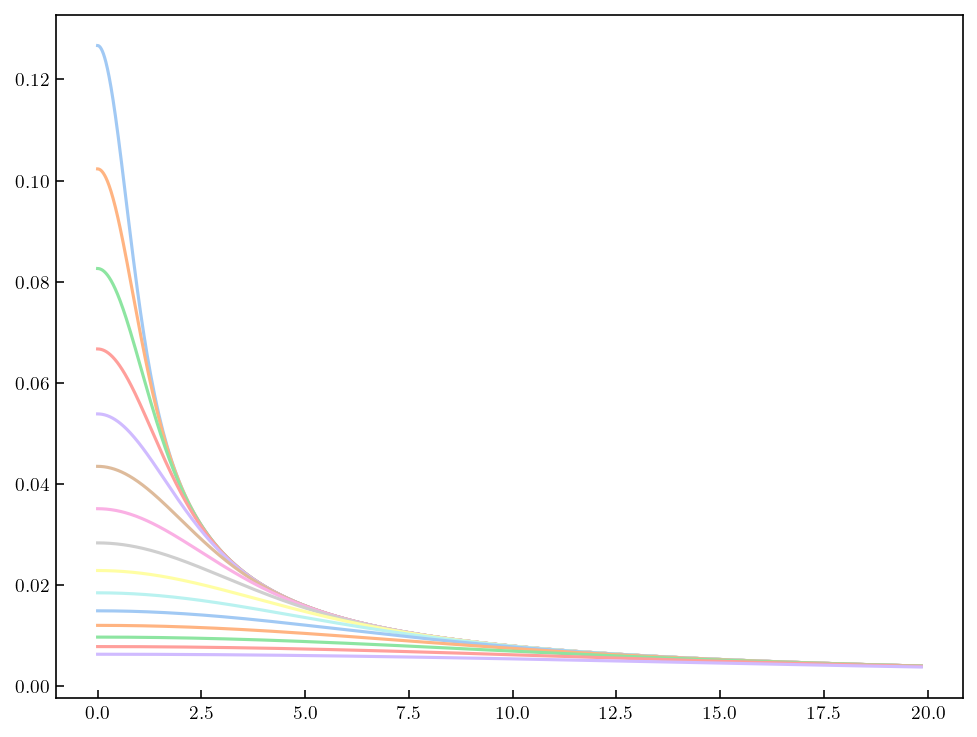

In [9]:
plt.plot(r[r<20], charge.pred_train[r<20]);

In [10]:
pred_valid_full = np.stack([charge.predict(p_i, use_full_solution=True) for p_i in p_valid], axis=1)
pred_valid_test = np.stack([charge.predict(p_i, use_full_solution=False) for p_i in p_valid], axis=1)

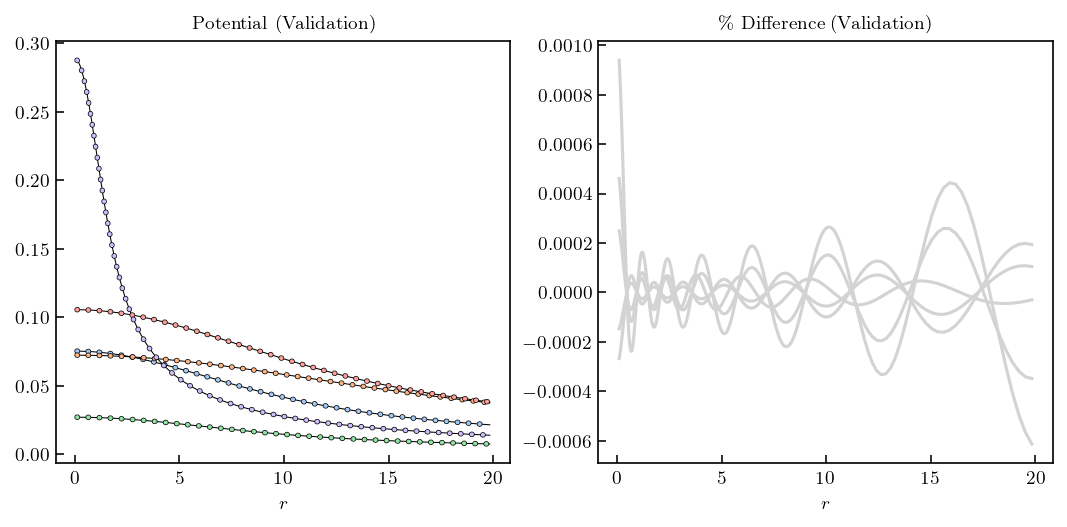

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.4))

r_mask = (r < 20) & (1e-1 < r)

ax = axes[0]
ax.plot(r[r_mask], pred_valid_full[r_mask], **FULL_KWARGS);
ax.plot(r[r_mask], pred_valid_test[r_mask], **PRED_KWARGS);
ax.set_xlabel("$r$")
ax.set_title("Potential (Validation)")

ax = axes[1]
ax.plot(r[r_mask], 100.0 * (pred_valid_full[r_mask]-pred_valid_test[r_mask]) / pred_valid_full[r_mask], c='lightgrey')
ax.set_title("\% Difference (Validation)")
ax.set_xlabel("$r$")
fig.savefig("galerkin_poisson.png")
# fig.tight_layout()

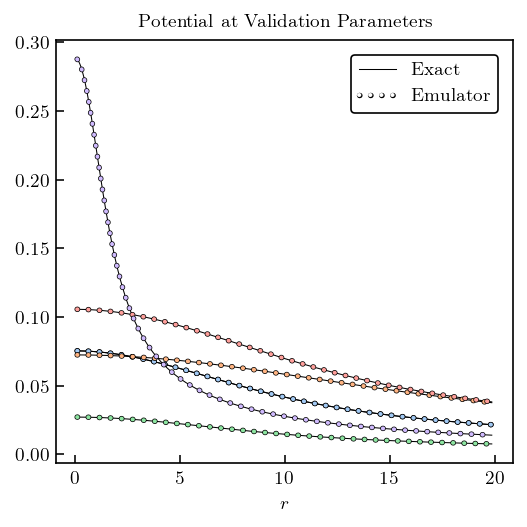

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))

r_mask = (r < 20) & (1e-1 < r)


ax.plot(r[r_mask], pred_valid_full[r_mask, 0], label="Exact", **FULL_KWARGS)
ax.plot(r[r_mask], pred_valid_test[r_mask, 0], label="Emulator", c='w', **PRED_KWARGS)
ax.plot(r[r_mask], pred_valid_full[r_mask], **FULL_KWARGS)
ax.plot(r[r_mask], pred_valid_test[r_mask], **PRED_KWARGS)
ax.set_xlabel("$r$")
ax.set_title("Potential at Validation Parameters")
ax.legend()
fig.savefig("galerkin_poisson_potential.png")

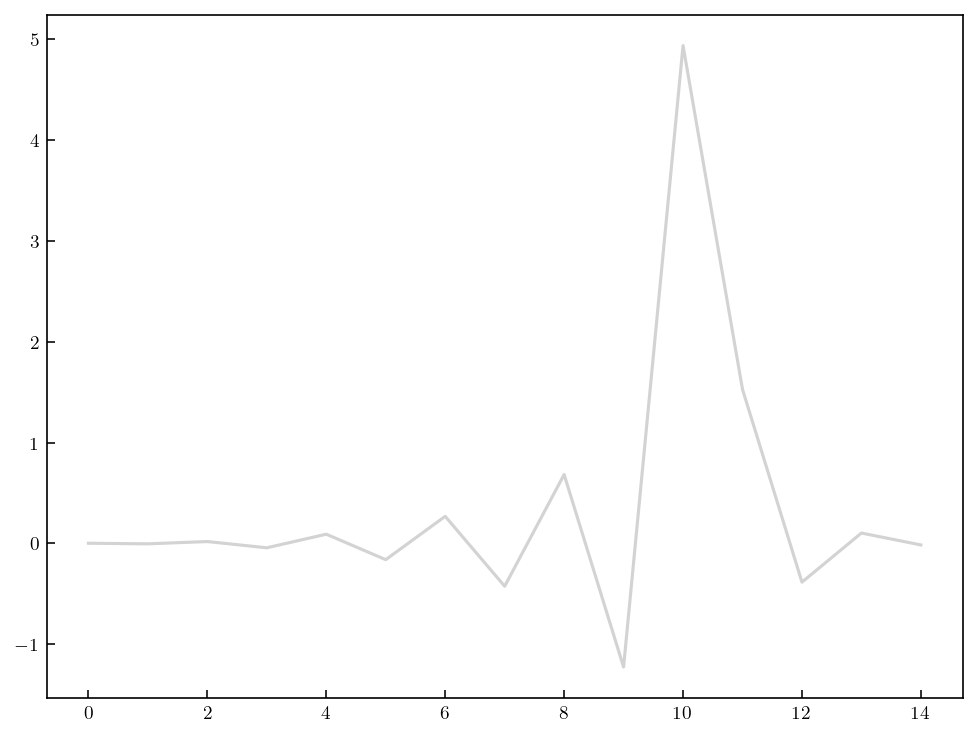

In [12]:
plt.plot(charge.coeffs(p_valid[0]), c='lightgrey');

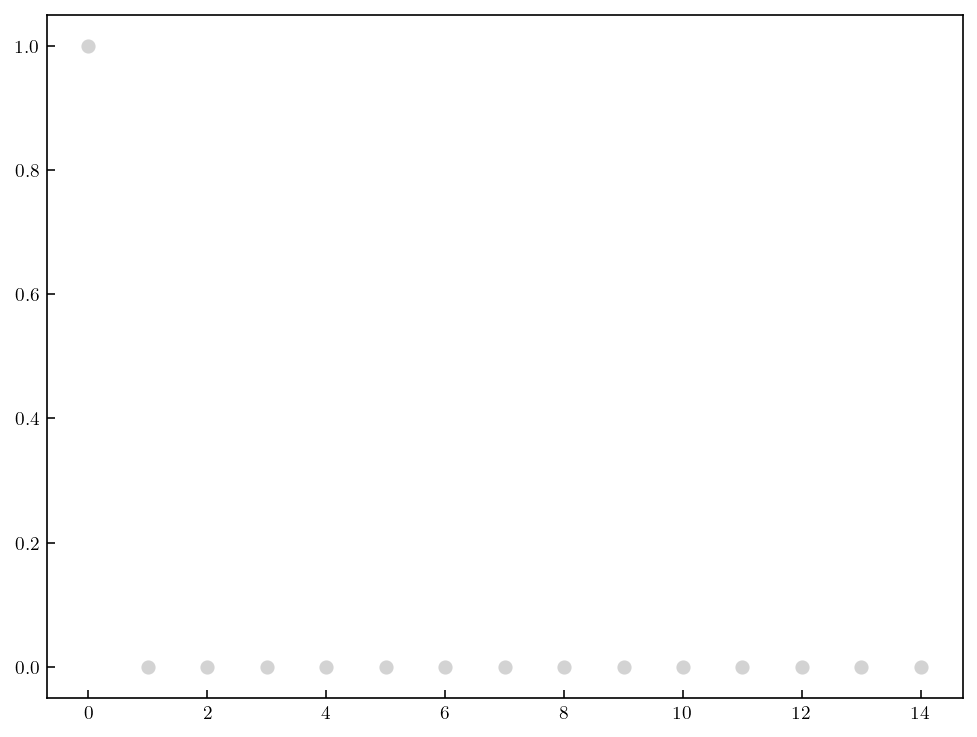

In [13]:
plt.scatter(np.arange(len(p_train)), charge.coeffs(p_train[0]), c='lightgrey');